# Exercise 2: Wine Classification (Continued)!

In [1]:
# Load packages we need
import sys
import os
import time

import numpy as np
import pandas as pd
import scipy as sp
import scipy.stats as stats
import sklearn

from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

# Let's check our software versions
print('### Python version: ' + __import__('sys').version)
print('### NumPy version: ' + np.__version__)
print('### SciPy version: ' + sp.__version__)
print('### Scikit-learn version: ' + sklearn.__version__)
print('------------')

# load our packages / code
sys.path.insert(1, '../common/')
import utils
import plots

/var/folders/z6/5n_s73l16t753clskkrk3n180000gq/T/ipykernel_85713/3725916248.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### Python version: 3.9.6 (default, Nov 10 2023, 13:38:27) 
[Clang 15.0.0 (clang-1500.1.0.2.5)]
### NumPy version: 1.26.3
### SciPy version: 1.12.0
### Scikit-learn version: 1.4.0
------------


ModuleNotFoundError: No module named 'utils'

In [2]:
# global parameters to control behavior of the pre-processing, ML, analysis, etc.
seed = 42**2

np.random.seed(seed) # deterministic seed for reproducibility

## Interesting stuff starts now

### Loading data

In [3]:
# Use pandas to load the data from compressed CSV
#wine_type = 'red'
wine_type = 'white'

df = pd.read_csv('../data/{}-wine-quality.csv'.format(wine_type), header=0, na_values='?', sep=' *; *', skipinitialspace=True, engine='python')

In [4]:
# Check that we loaded the data as expected
if wine_type == 'white':
    df_expected_shape = (4898,12)
else:
    df_expected_shape = (1599,12)
    
assert df.shape == df_expected_shape, 'Unexpected shape of df!'

In [5]:
# Quick tip: use info() to get a glance at the size and attributes of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [6]:
# Let's look at a few rows of our dataframe
df.head(10)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
5,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
6,6.2,0.32,0.16,7.0,0.045,30.0,136.0,0.9949,3.18,0.47,9.6,6
7,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
8,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
9,8.1,0.22,0.43,1.5,0.044,28.0,129.0,0.9938,3.22,0.45,11.0,6


In [7]:
# how many records do we have?
df.shape

(4898, 12)

### Pre-processing data

In [8]:
## header right now: fixed acidity;volatile acidity;citric acid;residual sugar;chlorides;free sulfur dioxide;total sulfur dioxide;density;pH;sulphates;alcohol;quality
col_names = df.columns
col_names = [x for x in col_names]

#### all columns are numerical and the last one 'quality' is what we want to predict
#### Note: quality is a score between 0 (very bad) and 10 (excellent)

In [9]:
# grab all the data as a numpy array
all_xy = np.asarray(df, dtype='float64')
assert all_xy.shape[1] == 12

label_col_idx = all_xy.shape[1]-1
features_col_idx = range(0, label_col_idx)

#### Let's separate features from labels

In [10]:
# separate features from the label
all_x = all_xy[:,features_col_idx]
all_y = all_xy[:,label_col_idx]
all_y = all_y.astype(int)

### Train, Test, Validation Split

In [11]:
# now split between train, test, and validation
prop_vec = [14, 3, 3]
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(all_x, all_y, prop_vec, shuffle=True)

In [12]:
# sanity check shapes
train_x.shape, train_y.shape, test_x.shape, test_y.shape, val_x.shape, val_y.shape

((3429, 11), (3429,), (735, 11), (735,), (734, 11), (734,))

### Stats & Looking at the data

In [13]:
# what does the distribution of labels look like?
label_name = col_names[-1]
utils.print_array_hist(train_y, label=label_name)

--- quality ---
3: 13
4: 118
5: 1014
6: 1536
7: 622
8: 121
9: 5


### Clearly, this is not a balanced dataset (we will see later on why this can matter)

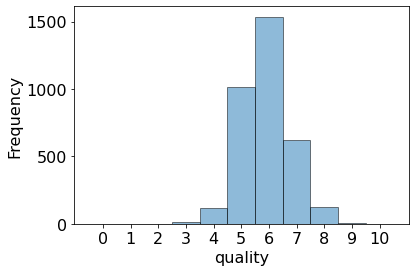

In [14]:
# let's plot a histogram to visualize the distribution of labels
bins = np.arange(-1, 11) + 0.5

plt.hist(train_y, bins, density=False, alpha=0.5, edgecolor='k', label=label_name)

plt.xticks(np.arange(11))
plt.xlabel(label_name)
plt.ylabel('Frequency')
plt.show()

### Question: what do you think is a good baseline for predicting the quality exactly?

In [15]:
# what does the distribution of features look like?
for i in range(train_x.shape[1]):
    utils.print_array_basic_stats(train_x[:, i], label=col_names[i])
    print()

--- fixed acidity ---
min: 3.80
max: 14.20
mean (+- std): 6.85 (+- 0.85)

--- volatile acidity ---
min: 0.08
max: 1.10
mean (+- std): 0.28 (+- 0.10)

--- citric acid ---
min: 0.00
max: 1.66
mean (+- std): 0.33 (+- 0.12)

--- residual sugar ---
min: 0.60
max: 31.60
mean (+- std): 6.37 (+- 4.98)

--- chlorides ---
min: 0.01
max: 0.35
mean (+- std): 0.05 (+- 0.02)

--- free sulfur dioxide ---
min: 2.00
max: 289.00
mean (+- std): 35.28 (+- 17.00)

--- total sulfur dioxide ---
min: 10.00
max: 440.00
mean (+- std): 138.24 (+- 42.44)

--- density ---
min: 0.99
max: 1.01
mean (+- std): 0.99 (+- 0.00)

--- pH ---
min: 2.72
max: 3.82
mean (+- std): 3.19 (+- 0.15)

--- sulphates ---
min: 0.25
max: 1.08
mean (+- std): 0.49 (+- 0.11)

--- alcohol ---
min: 8.00
max: 14.05
mean (+- std): 10.53 (+- 1.23)



### Question: Do the features even help us predict the quality?

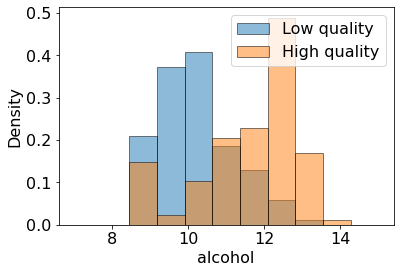

In [16]:
# plot feature distribution based on quality

#feature_idx = 0; bins = np.linspace(3, 12, 12)
#feature_idx = 3; bins = np.linspace(0, 70, 20)
feature_idx = 10; bins = np.linspace(7, 15, 12)

lowq_idx = train_y == 4 # low quality wines
highq_idx = train_y == 8 # high quality wines

plt.hist(train_x[lowq_idx,feature_idx], bins, density=True, alpha=0.5, edgecolor='k', label='Low quality')
plt.hist(train_x[highq_idx,feature_idx], bins, density=True, alpha=0.5, edgecolor='k', label='High quality')

plt.xlabel('{}'.format(col_names[feature_idx]))
plt.ylabel('Density')

plt.legend(loc='upper right')
plt.show()

### Can we look at the statistical information that features contain about the task in a systematic way?

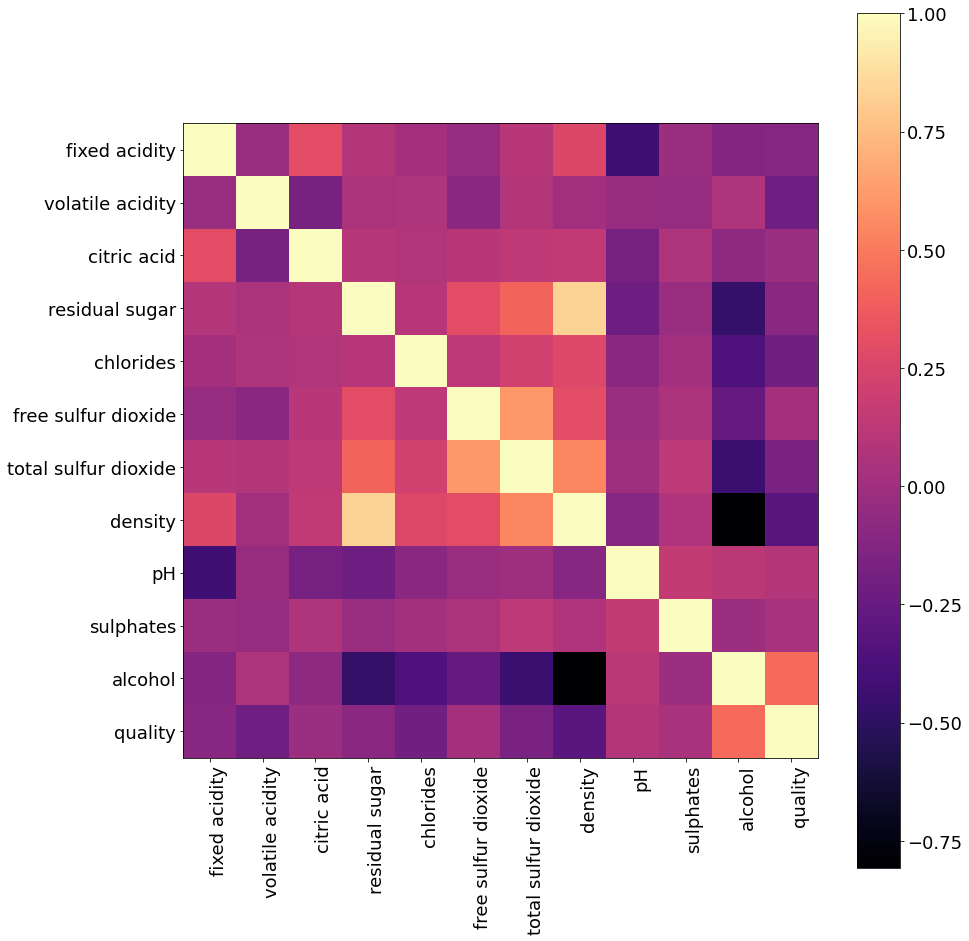

In [17]:
# Hint: this may be in your assignment!

train_xy = np.hstack((train_x, train_y.reshape(-1, 1)))

pairwise_corr = np.corrcoef(train_xy, rowvar=False)

plots.heatmap(pairwise_corr, col_names, col_names, rot=90, fsz=(14, 14))

### [Left as exercise]: use Pandas' scatter_matrix to look at scatter plots for the correlation. *Good exercise

In [18]:
## Ref: https://pandas.pydata.org/docs/reference/api/pandas.plotting.scatter_matrix.html

## How do we scale features??

### Let's implement [-1, 1] - normalization

In [19]:
low = -1.0
high = +1.0

#### Way #1: Use scikit-learn 

In [23]:
from sklearn.preprocessing import MinMaxScaler

scaled_all_x = all_x.copy() # make a copy

st = time.process_time()

# we can use min-max scaler for this, but we need to specify the feature range!
scaler = MinMaxScaler(feature_range=(low, high))

# let's do everything on all_x and then we can split it again later
scaled_all_x = scaler.fit_transform(scaled_all_x)
scaled_all_x_way1 = scaled_all_x

et = time.process_time()

print('Time (Scikit-Learn MinMaxScaler): {:.4f} seconds'.format(et - st))

Time (Scikit-Learn MinMaxScaler): 0.0029 seconds


#### Way #2: Do it manually/with numpy (the slow way; don't do this!)

In [24]:
scaled_all_x = all_x.copy() # make a copy

st = time.process_time()

(rows, cols) = scaled_all_x.shape
# iterate over each feature
for j in range(0, cols):
    feature_j_min = np.inf
    feature_j_max = -np.inf
    # iterate over each row
    for i in range(0, rows):
        if scaled_all_x[i,j] > feature_j_max:
            feature_j_max = scaled_all_x[i,j]
        if scaled_all_x[i,j] < feature_j_min:
            feature_j_min = scaled_all_x[i,j]
            
    # iterate over each row one last time
    for i in range(0, rows):
        scaled_all_x[i,j] = (scaled_all_x[i,j] - feature_j_min)/(feature_j_max - feature_j_min)
        scaled_all_x[i,j] *= (high - low)
        scaled_all_x[i,j] += low

scaled_all_x_way2 = scaled_all_x

et = time.process_time()

print('Time (manually slow/bad way): {:.4f} seconds'.format(et - st))

Time (manually slow/bad way): 0.1968 seconds


#### Way #3: Do it manually/with numpy (reasonably!)

In [25]:
scaled_all_x = all_x.copy() # make a copy

st = time.process_time()

(rows, cols) = scaled_all_x.shape
# iterate over each feature
for j in range(0, cols):
    minv = np.amin(scaled_all_x[:,j])
    maxv = np.amax(scaled_all_x[:,j])
    scaled_all_x[:,j] -= minv
    scaled_all_x[:,j] /= (maxv - minv)
    scaled_all_x[:,j] = scaled_all_x[:,j] * (high - low) + low
    
scaled_all_x_way3 = scaled_all_x


et = time.process_time()
print('Time (manually reasonable way): {:.4f} seconds'.format(et - st))

Time (manually reasonable way): 0.0035 seconds


#### Way #4: Do it manually/with numpy (better way!)

In [27]:
scaled_all_x = all_x.copy() # make a copy

st = time.process_time()

mins = np.amin(scaled_all_x, axis=0)
maxs = np.amax(scaled_all_x, axis=0)
scaled_all_x -= mins
scaled_all_x /= (maxs - mins)
scaled_all_x = scaled_all_x * (high - low) + low
    
scaled_all_x_way4 = scaled_all_x

et = time.process_time()
print('Time (manually better way): {:.4f} seconds'.format(et - st))

Time (manually better way): 0.0025 seconds


## *[Left as exercise] check that all four arrays scaled_all_x_way1,2,3,4 are identical (up to numerical precision...)

### *[Left as exercise] compare the four ways' performance by putting the code of each one in a function, then measure the time in a loop 100 times and average the results. Which way is fastest??

## Let's split the *scaled* data!

In [28]:
# now split between train, test, and validation!
train_x, train_y, test_x, test_y, val_x, val_y = utils.train_test_val_split(scaled_all_x, all_y, prop_vec, shuffle=True, seed=seed)

In [29]:
# what does the distribution of features look like now that we have done scaling?
for i in range(train_x.shape[1]):
    utils.print_array_basic_stats(train_x[:, i], label=col_names[i])
    print()

--- fixed acidity ---
min: -1.00
max: 1.00
mean (+- std): -0.41 (+- 0.16)

--- volatile acidity ---
min: -1.00
max: 1.00
mean (+- std): -0.61 (+- 0.20)

--- citric acid ---
min: -1.00
max: 1.00
mean (+- std): -0.60 (+- 0.15)

--- residual sugar ---
min: -1.00
max: 1.00
mean (+- std): -0.82 (+- 0.16)

--- chlorides ---
min: -1.00
max: 1.00
mean (+- std): -0.78 (+- 0.14)

--- free sulfur dioxide ---
min: -0.99
max: 1.00
mean (+- std): -0.77 (+- 0.12)

--- total sulfur dioxide ---
min: -1.00
max: 1.00
mean (+- std): -0.40 (+- 0.20)

--- density ---
min: -1.00
max: 1.00
mean (+- std): -0.73 (+- 0.12)

--- pH ---
min: -1.00
max: 0.98
mean (+- std): -0.15 (+- 0.28)

--- sulphates ---
min: -0.93
max: 0.95
mean (+- std): -0.37 (+- 0.27)

--- alcohol ---
min: -1.00
max: 1.00
mean (+- std): -0.20 (+- 0.40)



## Let's train a model

#### SVM classifier

In [30]:
from sklearn.svm import SVC, LinearSVC
from sklearn.base import clone

# Step 1: instantiate the model and set hyperparameters
## refer to: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
svm = SVC(kernel='linear', random_state=seed)

# Step 2: train the model (we use the training set)
_ = svm.fit(train_x, train_y)

#### KNN classifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier
# Step 1: instantiate the model and set hyperparameters
## refer to: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
knn = KNeighborsClassifier(n_neighbors=1)

# Step 2: train the model (we use the training set)
_ = knn.fit(train_x, train_y)

### Let's evaluate our models!

In [32]:
# Evaluate the models
# define a function to calculate accuracy
def model_accuracy(model, x, true_y):
    pred = model.predict(x)
    return np.sum(pred == true_y) / true_y.shape[0]

def evaluate_model(name, model, train_x, train_y, val_x, val_y, verb=True):
    train_acc = model_accuracy(model, train_x, train_y)
    val_acc = model_accuracy(model, val_x, val_y)
    if verb:
        print('[{}] Train accuracy: {:.2f}%, Val accuracy: {:.2f}%'.format(name, train_acc*100, val_acc*100))
    return train_acc, val_acc

In [33]:
_ = evaluate_model('SVM', svm, train_x, train_y, val_x, val_y)
_ = evaluate_model('KNN', knn, train_x, train_y, val_x, val_y)

[SVM] Train accuracy: 52.58%, Val accuracy: 50.95%
[KNN] Train accuracy: 100.00%, Val accuracy: 65.53%


### Q: Wait. What's going on with 100% accuracy?

### Q: Is around 50% a good model? Why or why not?

In [30]:
#
utils.print_array_hist(train_y, label='Label distribution')
#

--- Label distribution ---
3: 15
4: 114
5: 1038
6: 1537
7: 603
8: 118
9: 4


## What is an appropriate baseline?

In [31]:
### Baselines?
# baseline: random between 1 and 10
# --> baseline accuracy: ~10%

# better baseline: predict the mode
mode = stats.mode(train_y)[0]
print('Mode: {}'.format(mode)) 

Mode: 6


In [32]:
baseline_pred_y_train = (np.ones_like(train_y) * mode).astype(int)
baseline_pred_y_val = (np.ones_like(val_y) * mode).astype(int)

In [33]:
## How good is the baseline?
def pred_accuracy(true_y, pred_y):
    return np.sum(pred_y == true_y) / true_y.shape[0]

def evaluate_baseline(name, train_y, pred_y_train, val_y, pred_y_val):
    train_acc = pred_accuracy(train_y, pred_y_train)
    val_acc = pred_accuracy(val_y, pred_y_val)
    print('[{}] Training accuracy: {:.2f}%, Validation accuracy: {:.2f}%'.format(name, train_acc*100, val_acc*100))

evaluate_baseline('Baseline (mode)', train_y, baseline_pred_y_train, val_y, baseline_pred_y_val)

[Baseline (mode)] Training accuracy: 44.82%, Validation accuracy: 42.23%


## Let's optimize hyperparameters!

In [34]:
# we can do a grid search
def train_and_eval(hyperparams_str, model, tr_x, tr_y, valset_x, valset_y, verb=True):
    model.fit(tr_x, tr_y)
    _, acc = evaluate_model(hyperparams_str, model, tr_x, tr_y, valset_x, valset_y, verb)
    return acc

i=0

best_acc = 0
for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    for C in [0.1, 1.0, 10.0]:
        svm = SVC(kernel=kernel, C=C, random_state=seed)
        hypp_str = 'kernel=\'{}\', C={}'.format(kernel, C)
        
        print('Combination {}: {}'.format(i, hypp_str))
        acc = train_and_eval('SVM', svm, train_x, train_y, val_x, val_y)
        print()
        
        if acc > best_acc:
            best_hypp = hypp_str
            best_acc = acc
            best_model_gs = svm
            
        i += 1

Combination 0: kernel='linear', C=0.1
[SVM] Train accuracy: 52.41%, Val accuracy: 50.82%

Combination 1: kernel='linear', C=1.0
[SVM] Train accuracy: 52.58%, Val accuracy: 50.95%

Combination 2: kernel='linear', C=10.0
[SVM] Train accuracy: 52.38%, Val accuracy: 51.09%

Combination 3: kernel='rbf', C=0.1
[SVM] Train accuracy: 52.73%, Val accuracy: 51.36%

Combination 4: kernel='rbf', C=1.0
[SVM] Train accuracy: 57.33%, Val accuracy: 54.77%

Combination 5: kernel='rbf', C=10.0
[SVM] Train accuracy: 61.94%, Val accuracy: 54.77%

Combination 6: kernel='poly', C=0.1
[SVM] Train accuracy: 55.53%, Val accuracy: 51.91%

Combination 7: kernel='poly', C=1.0
[SVM] Train accuracy: 58.85%, Val accuracy: 55.72%

Combination 8: kernel='poly', C=10.0
[SVM] Train accuracy: 62.26%, Val accuracy: 55.72%

Combination 9: kernel='sigmoid', C=0.1
[SVM] Train accuracy: 44.82%, Val accuracy: 42.23%

Combination 10: kernel='sigmoid', C=1.0
[SVM] Train accuracy: 44.18%, Val accuracy: 43.32%

Combination 11: ker

In [35]:
## Why should we not use the test set?

In [35]:
orig_test_x = test_x
orig_test_y = test_y

test2_size = 30

test2_x = test_x[:test2_size]
test2_y = test_y[:test2_size]

test_x = test_x[test2_size:]
test_y = test_y[test2_size:]

In [36]:
best_acc = 0
best_hypp = None

trsz = 300

it = 0
for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    for C in np.linspace(0.01, 10.0, 1000):
        svm = SVC(kernel=kernel, C=C, random_state=seed)
        hypp_str = 'kernel=\'{}\', C={}'.format(kernel, C)
        
        # notice we are using test2 as validation!
        acc = train_and_eval('SVM', svm, train_x[:trsz], train_y[:trsz], test2_x, test2_y, verb=False)
        
        if acc > best_acc:
            best_hypp = hypp_str
            best_acc = acc
            best_C = C
            best_kernel = kernel
            best_model = svm
            
        it += 1
        
        if it % 10 == 0:
            sys.stdout.write('.')
            sys.stdout.flush()
            
print('\nBest hyperparams: {}, Accuracy: {}'.format(best_hypp, best_acc))

................................................................................................................................................................................................................................................................................................................................................................................................................
Best hyperparams: kernel='poly', C=4.52, Accuracy: 0.6333333333333333


In [37]:
#best_model = SVC(kernel=best_kernel, C=best_C, random_state=seed).fit(train_x, train_y)

_ = evaluate_model('SVM (hyperparams tuned on test2) -- val = test2', best_model, train_x, train_y, test2_x, test2_y)
_ = evaluate_model('SVM (hyperparams tuned on test2) -- val = test', best_model, train_x, train_y, test_x, test_y)

[SVM (hyperparams tuned on test2) -- val = test2] Train accuracy: 49.46%, Val accuracy: 63.33%
[SVM (hyperparams tuned on test2) -- val = test] Train accuracy: 49.46%, Val accuracy: 49.65%


In [38]:
_ = evaluate_model('SVM (hyperparams tuned on test2) -- val = orig_test', best_model, train_x, train_y, orig_test_x, orig_test_y)

[SVM (hyperparams tuned on test2) -- val = orig_test] Train accuracy: 49.46%, Val accuracy: 50.20%


### How about the model we found before during the first grid search (the one optimized on our validation set)?

In [39]:
_ = evaluate_model('SVM (hyperparams tuned on val) -- val = val', best_model_gs, train_x, train_y, val_x, val_y)
_ = evaluate_model('SVM (hyperparams tuned on val) -- val = orig_test', best_model_gs, train_x, train_y, orig_test_x, orig_test_y)

[SVM (hyperparams tuned on val) -- val = val] Train accuracy: 58.85%, Val accuracy: 55.72%
[SVM (hyperparams tuned on val) -- val = orig_test] Train accuracy: 58.85%, Val accuracy: 55.92%


## BTW Can you save a trained model? yes!

In [40]:
import joblib
# you can use pickle instead but joblib is recommended

fp = './ex2-best_svm_gs.joblib'

# to save
joblib.dump(best_model_gs, fp) 

# to load it back (later)
best_model_gs_loaded = joblib.load(fp) 

## note: it may not work right if you load the model saved with a different version of scikit-learn/numpy!
## same applies to the version of Python of course!

In [41]:
## is it really the same model?
print(best_model_gs)
_ = evaluate_model('SVM (saved)', best_model_gs, train_x, train_y, val_x, val_y)

print(best_model_gs_loaded)
_ = evaluate_model('SVM (loaded)', best_model_gs_loaded, train_x, train_y, val_x, val_y)

SVC(kernel='poly', random_state=1764)
[SVM (saved)] Train accuracy: 58.85%, Val accuracy: 55.72%
SVC(kernel='poly', random_state=1764)
[SVM (loaded)] Train accuracy: 58.85%, Val accuracy: 55.72%


### *[Left as exercise] wrap joblib.dump/load into functions to save/load models but which additionally check that the versions of libraries (i.e., scikit-learn, numpy) and python are the same. For this, save an additional .json file (hint you can save a dict into a json file in one or two lines) which details the version. When you load back the model with joblib make sure the libraries & python versions match.